In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy.signal as sp
import numpy.random as rnd
import ssid

%matplotlib inline

In [2]:
def generalizedPlant(A,B,C,D,Cov,dt):
    CovChol = la.cholesky(Cov,lower=True)
    NumStates = len(A)

    B1 = CovChol[:NumStates,:]
    B2 = B

    Bbig = np.hstack((B1,B2))

    D1 = CovChol[NumStates:,:]
    D2 = D
    Dbig = np.hstack((D1,D2))

    P = (A,Bbig,C,Dbig,dt)
    return P


In [9]:
# Define the plant
dt = .1
k1 = 1.
k2 = 2.
c1 = 2.
c2 = 2.
m1 = 1.
m2 = 1.
Kmat = np.array([[k1+k2,-k2],
                 [-k2,k2]])
Cmat = np.diag([c1,c2])

Mmat  = np.diag([m1,m2])


Ac = np.zeros((4,4))

Ac[:2,2:] = np.eye(2)
Ac[2:,:2] = -la.solve(Mmat,Kmat,sym_pos=True)
Ac[2:,2:] = -la.solve(Mmat,Cmat,sym_pos=True)
A = np.eye(4) + dt * Ac

Bc = np.zeros((4,2))
Bc[2:] = la.inv(Mmat)


B = dt * Bc
C = np.zeros((2,4))
C[:,:2] = np.eye(2)

NumInputs = B.shape[1]
NumOutputs = C.shape[0]

D = np.zeros((NumOutputs,NumInputs))

NumStates = len(A)
NumOutputs,NumInputs = D.shape

Q = .1 * np.eye(NumStates) * dt 
S = np.zeros((NumStates,NumOutputs))
R = .1 * np.eye(NumOutputs) / dt

CovTop = np.hstack((Q,S))
CovBot = np.hstack((S.T,R))
Cov = np.vstack((CovTop,CovBot))

P = generalizedPlant(A,B,C,D,Cov,dt)

In [10]:
# Generate an input to the plant.
# use inpdendent OU processes
theta = .01
AU = (1- dt * theta) * np.eye(NumInputs)
BU = 10 * np.eye(NumInputs) * np.sqrt(dt)
CU = np.eye(NumInputs)
DU = np.zeros((NumInputs,NumInputs)) / np.sqrt(dt)
# Sampling rate of 1
USys = (AU,BU,CU,DU,dt)
NumURows = 10
NumUCols = 10000
NumU = 2 * NumURows + NumUCols - 1
Time = np.arange(NumU)
uu = rnd.randn(NumU,NumInputs)
# u is the actual input
tu,u,xu = sp.dlsim(USys,uu)

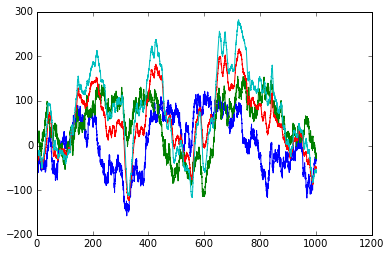

In [11]:
# Simulate the plant with the generated input as well as noise
w = rnd.randn(NumU,NumStates+NumOutputs)
bigU = np.hstack((w,u))
tout,y,xout = sp.dlsim(P,bigU)
plt.plot(tout,u)
plt.plot(tout,y)

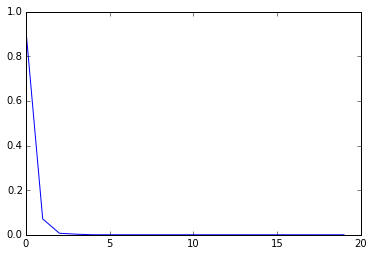

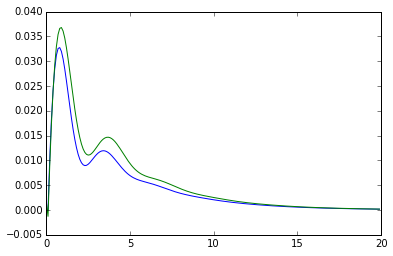

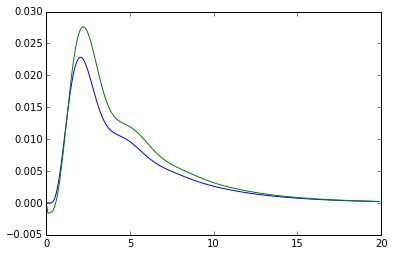

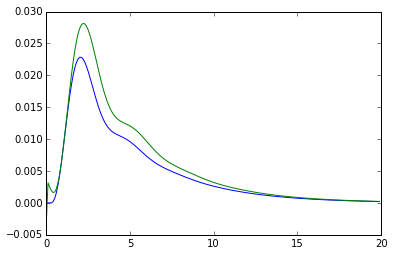

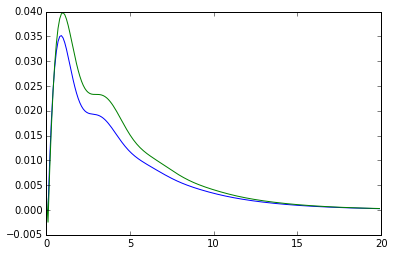

In [14]:
# Identify matrices using the N4SID algorithm
AID,BID,CID,DID,CovID,S = ssid.N4SID(u.T,y.T,NumURows,NumUCols,4)
# For conistency with the Subspace ID literature, 
# we transpose the signals so that each input and output instance is a column vector
# This is opposite from the lsim convention

# Check the singular values
plt.plot(S / S.sum())

# Check how the computed impulse resonse compares.
plt.figure()
NhSteps = 200
tout,hTrue = sp.dimpulse((A,B,C,D,dt),t=dt * np.arange(NhSteps))
tout,hID = sp.dimpulse((AID,BID,CID,DID,dt),t=dt*np.arange(NhSteps))
for i in range(NumOutputs):
    for j in range(NumInputs):
        plt.figure()
        plt.plot(tout,hTrue[j][:,i])
        plt.plot(tout,hID[j][:,i])

In [13]:
print Cov
print CovID

[[ 0.01  0.    0.    0.    0.    0.  ]
 [ 0.    0.01  0.    0.    0.    0.  ]
 [ 0.    0.    0.01  0.    0.    0.  ]
 [ 0.    0.    0.    0.01  0.    0.  ]
 [ 0.    0.    0.    0.    1.    0.  ]
 [ 0.    0.    0.    0.    0.    1.  ]]
[[  2.55872821e-07  -5.54226661e-08  -1.39119953e-06   2.05736566e-07
    1.45504746e-06   1.06987357e-06]
 [ -5.54226661e-08   1.52362034e-06  -1.37917760e-07  -6.44714178e-06
   -1.16244900e-05   7.27767196e-06]
 [ -1.39119953e-06  -1.37917760e-07   1.59620446e-05   3.50438992e-06
    5.43198419e-05   1.15223438e-04]
 [  2.05736566e-07  -6.44714178e-06   3.50438992e-06   5.10635953e-05
   -1.12370400e-04   1.44698572e-04]
 [  1.45504746e-06  -1.16244900e-05   5.43198419e-05  -1.12370400e-04
    1.14102674e+00   3.00243760e-02]
 [  1.06987357e-06   7.27767196e-06   1.15223438e-04   1.44698572e-04
    3.00243760e-02   1.16976885e+00]]
